In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from scipy import stats, optimize
from scipy import linalg as scilin
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from itertools import product
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import sympy as sym

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
sym.init_printing()

## Setup the True Parameters

In [181]:
equity_price = 0.50
vol_price = -7
phi0 = -.17
c0 = .1
delta0 = 1.22
rho0 = .4
time_dim = 3000

## Setup the Simulation Functions

In [182]:
def simulate_autoregressive_gamma(rho=0, c=1, delta=1, initial_point=None, time_dim=100,
                                  state_date='2000-01-01'):
    """
    This function provides draws from the ARG(1) process of Gourieroux & Jaiak
    
    Parameters
    --------
    rho : scalar
        AR(1) coefficient
    delta : scalar
        intercept
    c : scalar
        scale
    Returns
    -----
    draws : dataframe
    """
    
    # If initial_point is not specified, we start at the unconditional mean.
    
    initial_point = (c * delta) / (1 - rho)
    
    # The conditional distribution of an ARG(1) process is non-centered Gamma, which has a representation as a 
    # Poisson mixture of Gamma
    
    draws = [initial_point]
    
    for _ in tqdm_notebook(range(time_dim)):
        
        latent_var = stats.poisson.rvs(mu = rho * draws[-1] / c)
        draws.append(stats.gamma.rvs(a=delta+latent_var, scale=c))
    
    draws = pd.DataFrame(draws[1:], pd.date_range(start=state_date, freq='D', periods=time_dim))
    return draws
    
    

In [183]:
def simulate_conditional_gaussian(vol_data, psi=1, beta=0, gamma=0, phi=0):
    """
    This function simulates conditional Gaussian random variables with mean
    
    $$E[r_{t+1} | \sigma^2_t, \sigma^2_{t+1}] = \psi \sigma^2_{t+1} + \beta \sigma^2_t + \gamma$$
    $$Var[r_{+t} | \sigma^2_t, \sigma^2_{t+1}] = (1 - \phi^2) \sigma^2_{t+1}$$
    
    Parameters
    ----------
    vol_data : pandas dataframe
        The volatility data. It must always be positive.
    psi : scalar
    beta : scalar
    gamma : scalar
    phi : scalar 
        It must be in [0,1]
    
    Returns
    -------
    data : pandas dataframe 
        This contains both the vol_data and the return data
    """
    
    mean = psi * vol_data.shift(1) + beta * vol_data + gamma
    var = (1 - phi**2) * vol_data.shift(1)
    
    draws = stats.norm.rvs(loc=mean.dropna(), scale=var.dropna().apply(np.sqrt))
    
    data = pd.DataFrame(np.column_stack([vol_data.values[1:], draws]), index=vol_data.index[1:],
                       columns=['vol', 'rtn'])
    
    return data

In [184]:
def simulate_data(equity_price=1, vol_price=0, rho=0, c=1, delta=1, phi=0, initial_point=None, time_dim=100,
                                  state_date='2000-01-01'):
    """
    This function takes the reduced-form paramters and risk prices and returns the data
    
    Parameters
    --------
    equity_price: scalar
    vol_price : scalar
    phi : scalar
        leverage
    rho : scalar
        persistence
    c : positive scalar
        scale
    initial_point: scalar, optional
        Starting value for the volatility
    time_dim : int, optional
        number of periods
    start_date : datelike, optional
        The time to start the data from.
        
    Returns
    -----
    draws : dataframe
    
    """
    vol_data = simulate_autoregressive_gamma(rho=rho, c=c, delta=1, initial_point=initial_point,
                                             state_date=pd.to_datetime(state_date) - pd.Timedelta('1 day'),
                                             time_dim=time_dim + 1)
    psi, beta, gamma = compute_paramters(phi=phi, equity_price=equity_price, vol_price=vol_price, c=c,
                                         rho=rho, delta=delta)
    data = simulate_conditional_gaussian(vol_data, psi=psi, beta=beta, gamma=gamma, phi=phi)
        
    return data

In [185]:
def compute_paramters(phi=0, equity_price=1, vol_price=0, c=1, rho=0, delta=1):
    """
    This function computes the means of the data in terms of the reduced form paramters and risk-prices
    
    Parameters
    ------
    phi : scalar
        leverage
    vol_price : scalar
    equity_price: scalar
    rho : scalar
        persistence
    c : positive scalar
        scale
    Returns
    --------
    psi : scalar
    beta : scalar
    gamma : scalar
    """
    
    psi = phi / np.sqrt(c * (1 + rho)) - (1 - phi**2) / 2 - ( 1- phi**2) * equity_price
    alpha = lambda x: rho * x / (1 + c * x)
    a = lambda x: psi * x + ((1 - phi**2) / 2) * x**2
    b = lambda x: delta * np.log(1 + c * x)
    
    beta = a(vol_price + alpha(equity_price - 1)) - a(vol_price + alpha(equity_price))
    gamma = b(vol_price + alpha(equity_price - 1)) - b(vol_price + alpha(equity_price))
    
    return psi, beta, gamma

## We now examine the distributions of simulated data

In [186]:
data = simulate_data(equity_price=equity_price, vol_price=vol_price, rho=rho0, c=c0, delta=delta0, phi=phi0,
                     time_dim=time_dim)

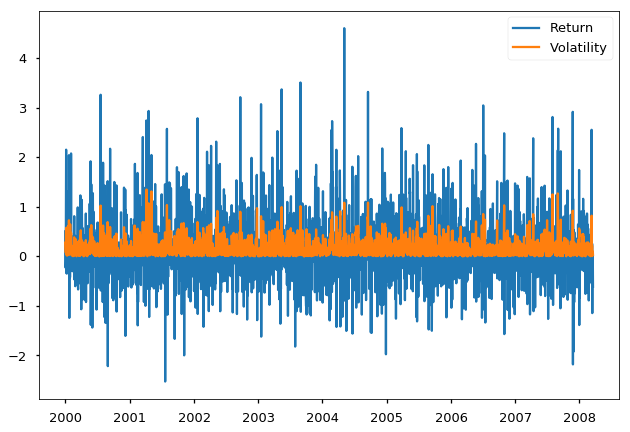

In [187]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return')
ax1.plot(data.vol, label='Volatility')
ax1.legend()
# ax1.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonth=(1,6)))
# ax1.xaxis.set_major_formatter(mpl.dates.AutoDateFormatter(ax1.xaxis.get_major_locator()))


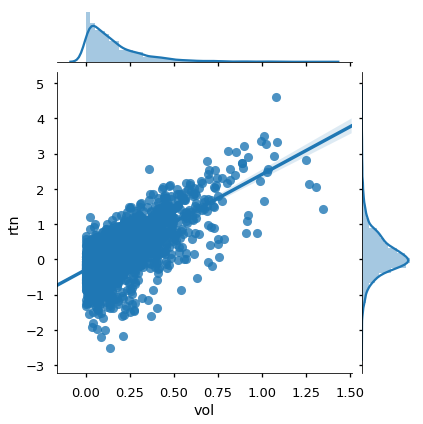

In [188]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [189]:
data.describe()

,vol,rtn
count,3000.000000,3000.000000
mean,0.165423,0.147936
std,0.168024,0.640502
min,0.000209,-2.527128
25%,0.047372,-0.209116
50%,0.116290,0.075362
75%,0.227662,0.458165
max,1.347378,4.603007


## We now define the moment conditions

In [190]:
x, y, rho, c, delta, phi, psi = sym.symbols('x y rho c delta phi psi')

In [191]:
mean = rho * x + c * delta
var = 2 * c * rho * x + c**2 * delta
mom1 = y - mean
mom2 = (y- mean) * x
mom3 = (y**2 - (var + mean**2))
mom4 = (y**2 - (var + mean**2)) * x
mom5 = (y**2 - (var + mean**2)) * x**2

In [192]:
vol_moments_sym = sym.Matrix([mom1,mom2, mom3, mom4, mom5])
vol_moments_lambda = sym.lambdify((x, y, rho, c, delta), vol_moments_sym)

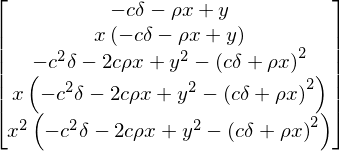

In [193]:
vol_moments_sym

In [194]:
def vol_moments(vol_data, *args):    
    return pd.DataFrame(np.squeeze(vol_moments_lambda(vol_data.values[1:], vol_data.values[:-1], *args)).T)

I use Sympy to compute the gradient

In [195]:
vol_squared_mom = vol_moments_sym.T @ vol_moments_sym
vol_squared_mom_grad = sym.lambdify((x, y, rho, c, delta), vol_squared_mom.jacobian([rho, c, delta]))

In [196]:
def vol_squared_moments_grad(vol_data, *args):
    return  pd.DataFrame(np.squeeze(vol_squared_mom_grad(vol_data.values[1:], vol_data.values[:-1], *args)).T, 
                         index=vol_data.index[1:]).dropna()

In [197]:
vol_moments_grad_lambda = sym.lambdify((x, y, rho, c, delta), vol_moments_sym.jacobian([rho, c, delta]))


In [198]:
def vol_moments_grad(vol_data, *args):
    mom_grad_in  = vol_moments_grad_lambda(vol_data.shift(1), vol_data, *args)
    return np.array([[np.nanmean(arr_in) for arr_in in arr_out] for arr_out in mom_grad_in])
                         

In [199]:
intercept, persistence = tsa.AR(data.vol).fit(maxlag=1).params
error_var = tsa.AR(data.vol).fit(maxlag=1).sigma2

From the model, we know that intercept = $ c * \delta$. We also know that the average error variance equals 
$ c^2 \delta * (2 \rho / 1 - \rho) + 1)$ Consequently, $c = error\_var / ( intercept * (2 \rho / 1 - \rho) + 1)) $ and delta = intercept / c


In [200]:
c_init = error_var / ( intercept * ( 2 * persistence / ( 1- persistence) + 1) )
delta_init = intercept / c_init

In [201]:
c_init

In [202]:
persistence

In [203]:
delta_init

In [204]:
num_vals = 50
cvals = np.linspace(0, 1,num_vals)
deltavals = np.linspace(0,1.5,num_vals)

In [205]:
plot_data = pd.DataFrame(np.asarray([(scale, intercept, vol_moments(data.vol, *[.5, scale, intercept]).apply(
    np.square).sum().mean())
     for scale, intercept in product(cvals, deltavals)]), columns=['c', 'delta', 'z'])
reshaped_x = plot_data.c.values.reshape((num_vals,num_vals))
reshaped_y = plot_data.delta.values.reshape((num_vals,num_vals))
reshaped_z = plot_data.z.values.reshape((num_vals,num_vals))

Text(0.5,0,'c')

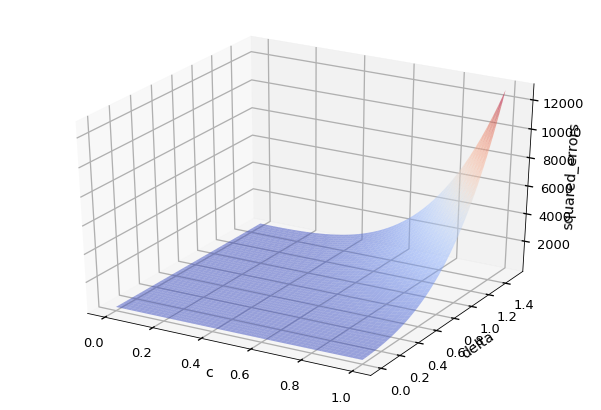

In [206]:
fig = mpl.pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(reshaped_x, reshaped_y, reshaped_z , cmap=cm.coolwarm, alpha=.5)


ax.set_ylabel('delta')
ax.set_zlabel('squared_errors')
ax.set_xlabel('c')
# ax.set_zlim(0, 1000)


In [207]:
def compute_vol_gmm():
    initial_result = optimize.minimize(lambda x: np.mean(vol_moments(data.vol, *x).values.ravel()**2),
                           x0=[persistence,c_init,delta_init], method="SLSQP",
                           jac= lambda x: np.mean(vol_squared_moments_grad(data.vol, *x), axis=0),
                           bounds=[(-1,1),(1e-5, 2), (1e-5,10)], options={'maxiter':200})
    root_inv_weight_matrix = scilin.cholesky(vol_moments(data.vol, *initial_result.x).cov(), lower=True)
    root_weight_matrix = scilin.solve_triangular(root_inv_weight_matrix, np.eye(len(root_inv_weight_matrix)))
    
    final_result = optimize.minimize(lambda x: np.mean((root_weight_matrix 
                                                       @ vol_moments(data.vol, *x).values.T).ravel()**2),
                           x0=initial_result.x, method="SLSQP",
                           bounds=[(-1,1),(1e-5, 2), (.01,10)], options={'maxiter':200})

    moment_derivative = vol_moments_grad(data.vol, *final_result.x)
    cov = np.linalg.inv(moment_derivative.T @ root_weight_matrix.T @ root_weight_matrix @ moment_derivative)

    return initial_result, cov / [data.vol.size -1 ]


In [208]:
final_result, cov = compute_vol_gmm()

In [209]:
final_result

     fun: 0.00907728152764481
     jac: array([  1.62883305e-03,   1.30019850e-03,   5.42652723e-05])
 message: 'Optimization terminated successfully.'
    nfev: 4
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 0.41480021,  0.09949534,  0.9682815 ])

In [210]:
cov

array([[  9.19968324e-05,  -3.31317314e-05,   1.37196705e-04],
       [ -3.31317314e-05,   3.23181240e-05,  -3.03602973e-04],
       [  1.37196705e-04,  -3.03602973e-04,   3.48713394e-03]])